In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time
from tqdm import tqdm
import collections
from collections import deque
import gc
import seaborn as sns
import scipy.cluster.hierarchy as spc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score, accuracy_score

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

import jpx_tokyo_market_prediction

from utility_script import *

!pip install --upgrade ta
import ta
from ta import add_all_ta_features
from ta.utils import dropna

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

  Preparing metadata (setup.py) ... - done
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=215daa17e2e9914dfdb2709248f6e9594e49815da8e5a0b4e86a310b156086e5
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta


In [2]:
'''
Notebook Parameters
'''
SEED = 0
N_STOCK_SAMPLE = 2000
N_DAY_SAMPLE = 300
N_FOLD = 5
STOCK_LIST = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv').loc[lambda x: x.Universe0==1].SecuritiesCode.sort_values().unique().tolist()[:N_STOCK_SAMPLE]
LAGS = {'1d':1, '3d':3, '1w':5, '1m':20, '3m':20*3, '6m':20*6, '12m':20*12}
# LAGS = {'3d':3, '1w':5}
MAX_DAYS_LAG = max(list(LAGS.values()))
WIN_SIZE = 500
JPX_PATH = '../input/jpx-tokyo-stock-exchange-prediction'
START_DATE, END_DATE = '2019-01-16', '2020-10-06'
# START_DATE, END_DATE = '2020-10-07', '2022-06-24'

In [3]:
class JPXData:
    def __init__(self, window_size, df_names):
        self.size = 0
        self.window_size = window_size
        self.df_names = df_names
        self.num_df = len(df_names)
        self.data = {df_name : pd.DataFrame() for df_name in df_names}
        self.row_counts = {df_name : [] for df_name in df_names}
        self.dates = []
        self.first_date, self.last_date = None, None
        self.features = []
        self.curr_features = None
        self.n_day_hist = 0
        self.init_folders()
        
    def init_folders(self):
        shutil.rmtree(path='./features', ignore_errors=True)
        os.mkdir('./features')
        
    def append_data(self):
        self.features.append(self.curr_features)
        self.n_day_hist += 1
        
    def archive_data(self):
        save_pkl(self.features, f'./features/features_{self.n_day_hist}')
        self.clear_hist()
        
    def clear_hist(self):
        self.features = []
        
    def push_forward(self, new_data, append, last):
        # assign names to new data assuming the same as df_names
        new_data = dict(zip(self.df_names, new_data))
        # case when no enough data
        if self.size < self.window_size:
            for df_name in self.df_names:
                self.data[df_name] = pd.concat([self.data[df_name], new_data[df_name]]).reset_index(drop=True)
                self.row_counts[df_name] = self.row_counts[df_name] + [new_data[df_name].shape[0]]
            self.dates = self.dates + [new_data[self.df_names[0]].Date.iloc[0]] 
            self.size += 1
        # general case (shift by 1 day)
        else:
            for df_name in self.df_names:
                self.data[df_name] = pd.concat([self.data[df_name].iloc[self.row_counts[df_name][0]:], new_data[df_name]]).reset_index(drop=True)
                self.row_counts[df_name] = self.row_counts[df_name][1:] + [new_data[df_name].shape[0]]
            self.dates = self.dates[1:] + [new_data[self.df_names[0]].Date.iloc[0]]  
        # update date range
        self.first_date, self.last_date = self.dates[0], self.dates[-1]
        # generate features
        if self.size == self.window_size:
            self.curr_features = get_features(self.data)
            if append==True:
                self.append_data()
                if (self.n_day_hist%20 == 0 and self.n_day_hist > 0) or last==True:
                    self.archive_data()
        log(f'Pushed to latest date: {self.last_date}')

In [4]:
def standard_dist(s, lag):
    tail_data = s.tail(LAGS[lag])
    return (s.iloc[-1] - tail_data.mean()) / tail_data.std()

def ma_pctg_ch(s, lag):
    return s.iloc[-1] / s.tail(LAGS[lag]).mean() - 1

def sharpe(s, lag):
    tail_data = s.tail(LAGS[lag])
    std = tail_data.std()
    if std > 0:
        sharpe_ratio = tail_data.mean() / tail_data.std()
    else:
        sharpe_ratio = 0
    return sharpe_ratio

In [5]:
def gen_ta_feats(df, n_day_ma, n_day_scale):
    # preprocess
    df = df \
        .sort_values(['SecuritiesCode','Date']) \
        .groupby('SecuritiesCode') \
        .tail(n_day_ma + n_day_scale) \
        .loc[:, ['SecuritiesCode','Open','High','Low','Close','Volume']] \
        .reset_index(drop=True)
    # gen TA feats
    df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=False) \
        .drop(['Open','High','Low','Close','Volume'], axis=1)
    ta_cols = df.columns.tolist()[1:]
    ta_cols = [c for c in ta_cols if c not in ['volatility_atr',
                                                 'trend_adx',
                                                 'trend_adx_pos',
                                                 'trend_adx_neg',
                                                 'trend_psar_up',
                                                 'trend_psar_down',
                                                 'momentum_kama']]
    ta_cols = ['volume_obv',
                 'volume_cmf',
                 'volume_fi',
                 'volume_em',
                 'volume_sma_em',
                 'volume_vpt',
                 'volume_mfi',
                 'volume_nvi',
                 'volatility_bbw',
                 'volatility_bbhi',
                 'volatility_bbli',
                 'volatility_kcw',
                 'volatility_kcp',
                 'volatility_kchi',
                 'volatility_kcli',
                 'volatility_ui',
                 'trend_macd_signal',
                 'trend_macd_diff',
                 'trend_vortex_ind_pos',
                 'trend_vortex_ind_neg',
                 'trend_mass_index',
                 'trend_dpo',
                 'trend_kst',
                 'trend_kst_diff',
                 'trend_ichimoku_conv',
                 'trend_stc',
                 'trend_cci',
                 'trend_visual_ichimoku_b',
                 'trend_aroon_up',
                 'trend_aroon_down',
                 'trend_psar_up_indicator',
                 'trend_psar_down_indicator',
                 'momentum_rsi',
                 'momentum_stoch_rsi_d',
                 'momentum_uo',
                 'momentum_wr',
                 'momentum_ao',
                 'momentum_roc',
                 'momentum_ppo',
                 'momentum_ppo_hist',
                 'momentum_pvo',
                 'momentum_pvo_hist',
                 'others_dlr']
    df = df[['SecuritiesCode'] + ta_cols]
    # scale by mean
    mean = df \
        .groupby('SecuritiesCode') \
        .tail(n_day_scale)[ta_cols] \
        .abs() \
        .mean()
    for c in ta_cols:
        df[c] = df[c] / mean[c]
    # take last row as features
    df = df.groupby('SecuritiesCode').tail(1)
    return df

In [6]:
%%time

def get_features(data):
    df_prices, df_sec_prices, df_fins, df_opts, df_trades = tuple(data.values())
#     df_prices, df_sec_prices, df_fins, df_opts, df_trades = tuple(data.data.values())

    # base table
    features = df_prices.loc[lambda x: x.Date==x.Date.iloc[-1]][['RowId','Date','SecuritiesCode']]

    # precalculate new columns
    cols = [c for c in df_prices.columns.tolist()[3:] if c!='ExpectedDividend']
    df_prices[cols] = df_prices.groupby('SecuritiesCode')[cols].ffill()
    df_prices['ret'] = df_prices.groupby('SecuritiesCode').Close.pct_change()
    ret_mkt = df_prices.groupby('Date').ret.mean()

    # market return and volatility
    for lag in ['3d','1w','1m','3m']:
        features[f'ret_mkt_{lag}'] = ret_mkt.tail(LAGS[lag]).sum()
        features[f'vol_mkt_{lag}'] = ret_mkt.tail(LAGS[lag]).std()

    # TA feats
    ta_feats = gen_ta_feats(df=df_prices, n_day_ma=52, n_day_scale=20)
    features = features.merge(ta_feats, how='inner', on='SecuritiesCode')

    '''
    Post-processing
    '''
    cols = [c for c in features.columns if c not in ['RowId','Date','SecuritiesCode']]
    features[cols] = features[cols].replace(np.inf, np.nan).replace(-np.inf, np.nan)
    features[cols] = features[cols].fillna(features[cols].mean())
    features[cols] = features[cols].astype(np.float32)

    return features

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [7]:
%%time

# initialize Data Object
data = JPXData(window_size=WIN_SIZE, df_names=['df_prices', 'df_sec_prices', 'df_fins', 'df_opts', 'df_trades'])

# read all files
df_prices = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/stock_prices.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]).reset_index(drop=True)
df_sec_prices = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/secondary_stock_prices.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]).reset_index(drop=True)
df_fins = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/financials.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]).reset_index(drop=True)
df_opts = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/options.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]).reset_index(drop=True)
df_trades = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/trades.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]).reset_index(drop=True)

# iterate dates
date_list = df_prices.Date.sort_values().drop_duplicates()
date_list = date_list.loc[lambda x: x < START_DATE].tail(WIN_SIZE-1).tolist() + date_list.loc[lambda x: (x>=START_DATE) & (x<=END_DATE)].tail(WIN_SIZE-1).tolist()
for i in range(len(date_list)):
    last = True if i==len(date_list)-1 else False
    data.push_forward([df.loc[lambda x: x.Date==date_list[i]] for df in [df_prices, df_sec_prices, df_fins, df_opts, df_trades]], append=True, last=last)

# release memory
del df_prices, df_sec_prices, df_fins, df_opts, df_trades
gc.collect()
    
save_pkl(data, 'data')

[2022-07-01 18:02:01] Pushed to latest date: 2017-01-04 00:00:00
[2022-07-01 18:02:01] Pushed to latest date: 2017-01-05 00:00:00
[2022-07-01 18:02:01] Pushed to latest date: 2017-01-06 00:00:00
[2022-07-01 18:02:01] Pushed to latest date: 2017-01-10 00:00:00
[2022-07-01 18:02:01] Pushed to latest date: 2017-01-11 00:00:00
[2022-07-01 18:02:01] Pushed to latest date: 2017-01-12 00:00:00
[2022-07-01 18:02:01] Pushed to latest date: 2017-01-13 00:00:00
[2022-07-01 18:02:02] Pushed to latest date: 2017-01-16 00:00:00
[2022-07-01 18:02:02] Pushed to latest date: 2017-01-17 00:00:00
[2022-07-01 18:02:02] Pushed to latest date: 2017-01-18 00:00:00
[2022-07-01 18:02:02] Pushed to latest date: 2017-01-19 00:00:00
[2022-07-01 18:02:02] Pushed to latest date: 2017-01-20 00:00:00
[2022-07-01 18:02:02] Pushed to latest date: 2017-01-23 00:00:00
[2022-07-01 18:02:02] Pushed to latest date: 2017-01-24 00:00:00
[2022-07-01 18:02:02] Pushed to latest date: 2017-01-25 00:00:00
[2022-07-01 18:02:02] Pus

In [8]:
# load features
path = './features'
features = pd.concat([pd.concat(load_pkl(f'{path}/{filename}')) for filename in os.listdir(path)]).sort_values('RowId').reset_index(drop=True)

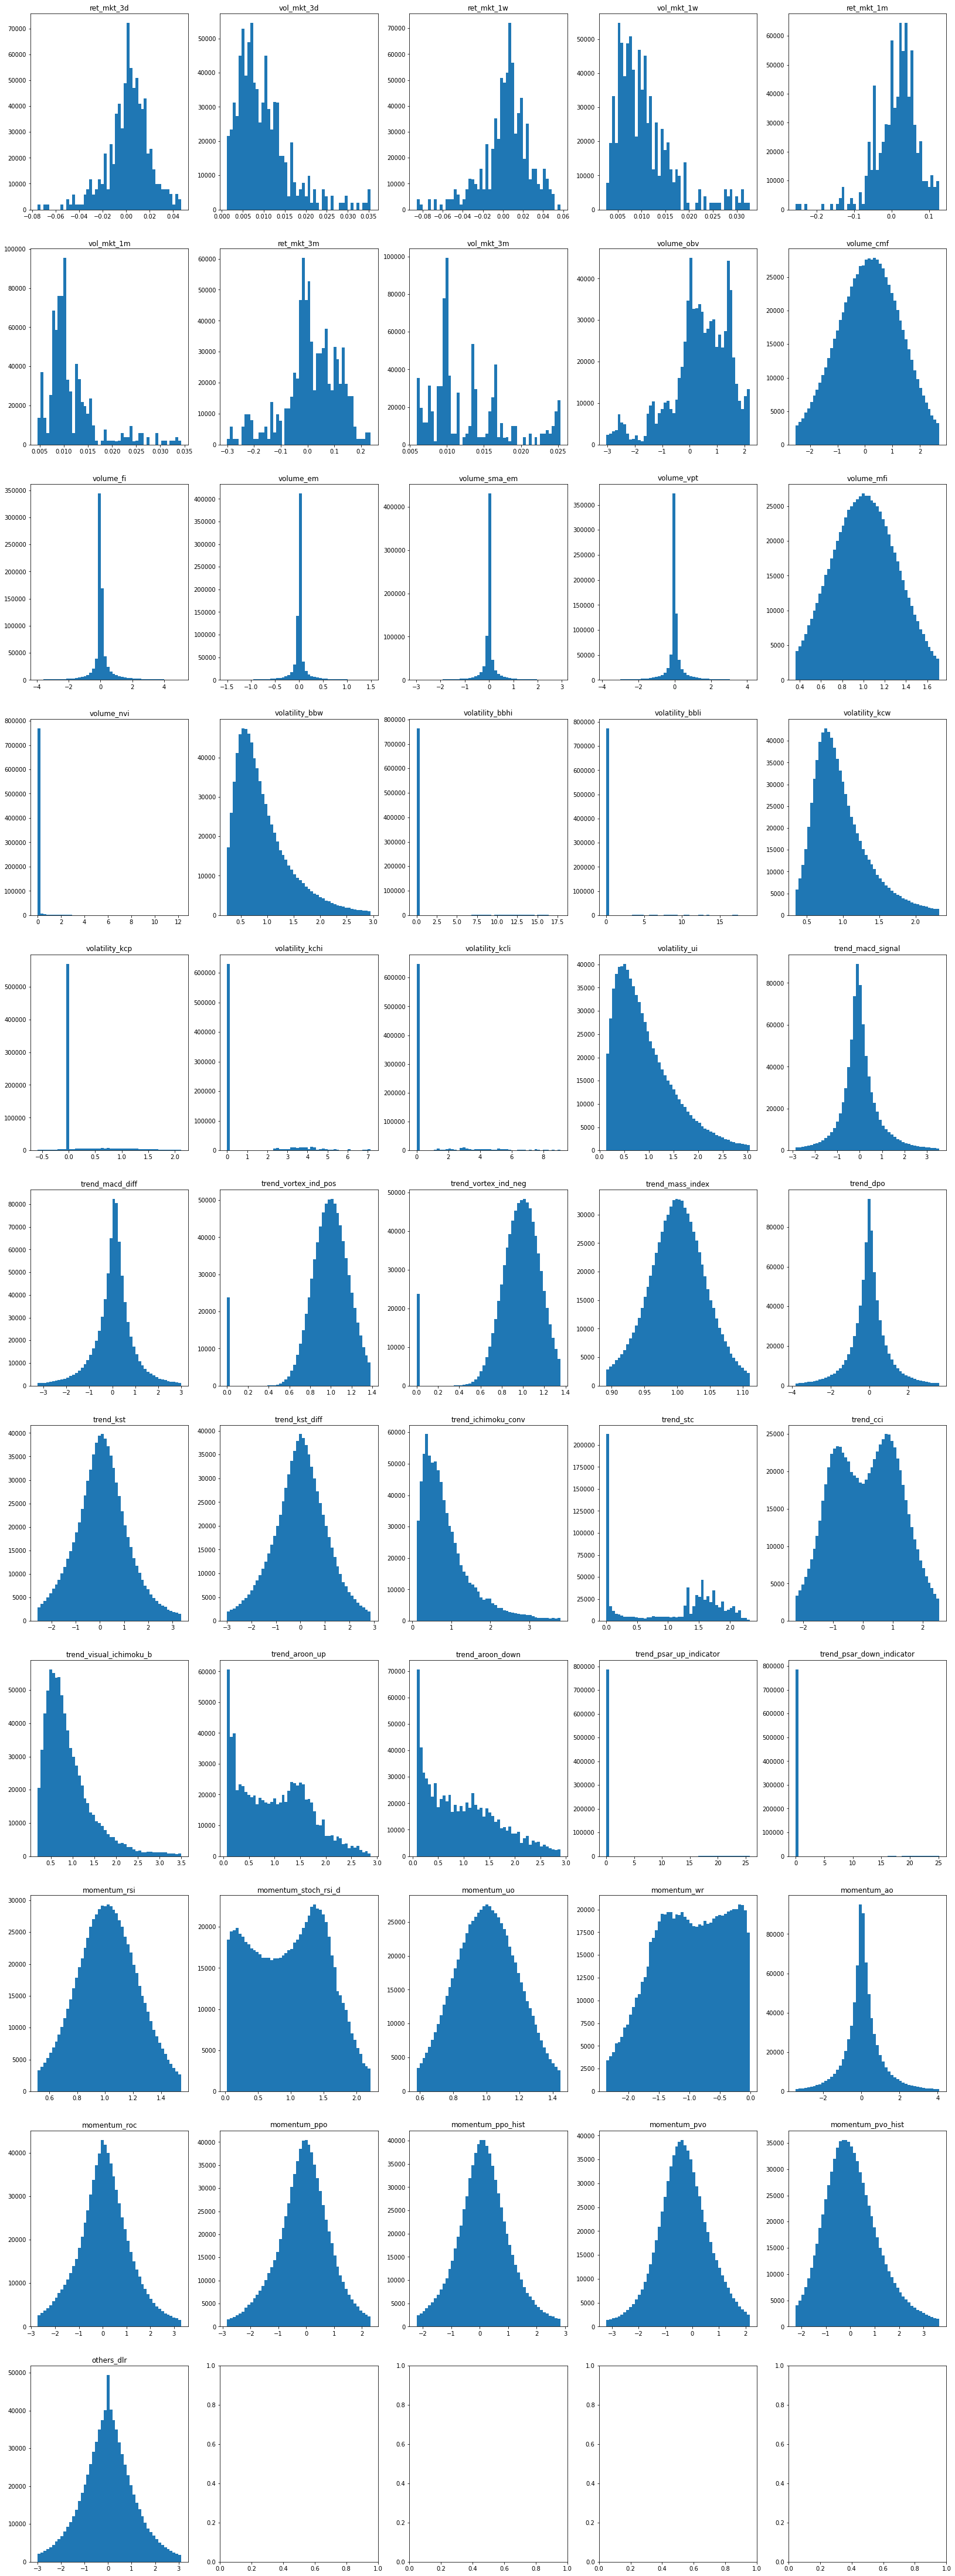

In [9]:
'''
Feature distributions
'''
n_id_cols = 3
n_col = 5
figsize = (28, 80)
top_q = 0.02
bins = 50

n_feats = features.shape[1] - n_id_cols
n_row = math.ceil(n_feats / n_col)
fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
for i, j in list(itertools.product(range(n_row), range(n_col))):
    try:
        s = features.iloc[:, n_id_cols + i*n_col + j]
        s = s.loc[lambda x: (x >= s.quantile(top_q)) & (x <= s.quantile(1-top_q))]
        axs[i,j].hist(x=s, bins=bins)
        axs[i,j].set_title(features.columns.tolist()[n_id_cols + i*n_col + j])
    except:
        continue

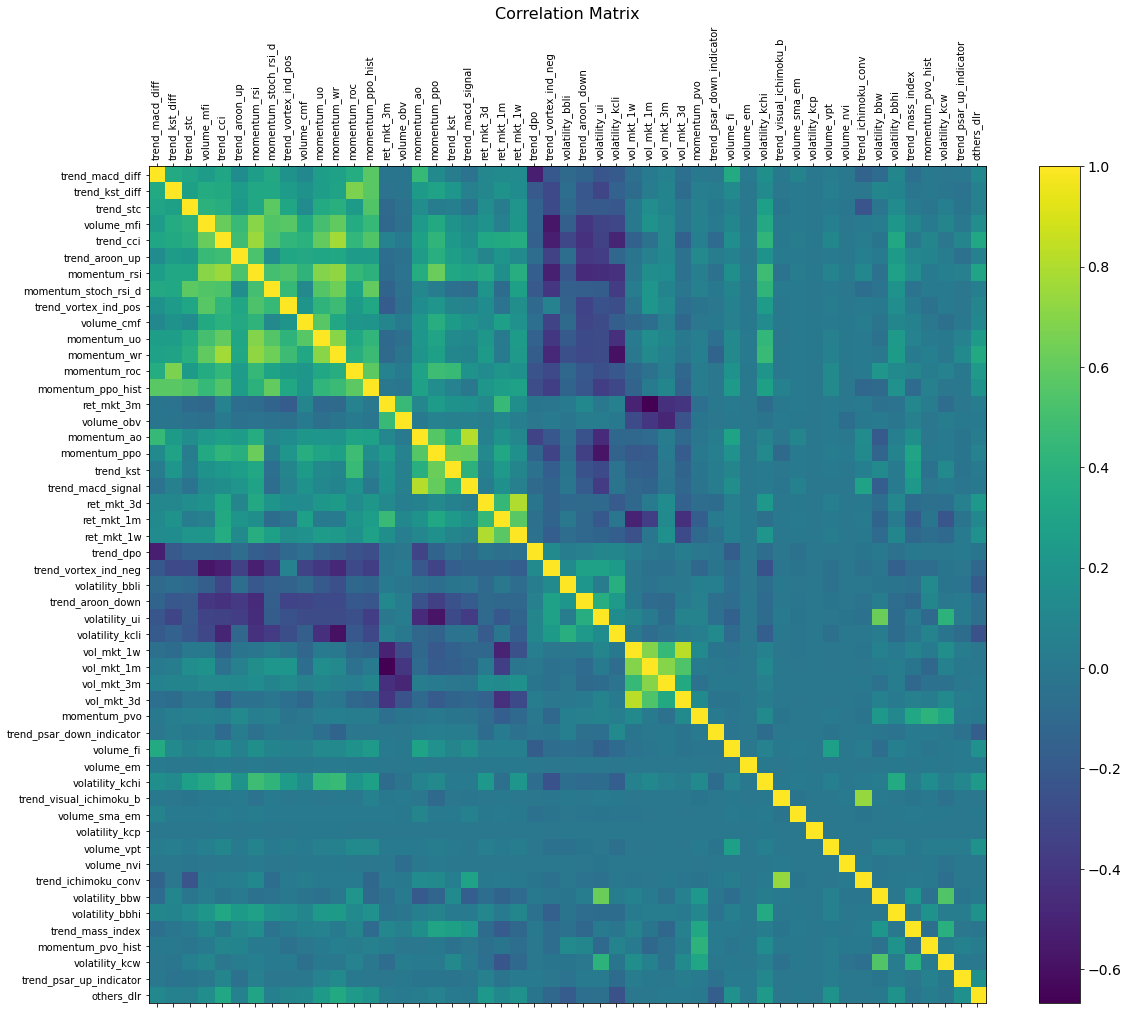

In [10]:
'''
Correlation
'''
# raw correlation table
corr = features.iloc[:,n_id_cols:].corr()
cols = [c for c in corr if corr[c].notnull().sum()==0]
corr = corr.drop(cols, axis=0).drop(cols, axis=1)
feat_names = corr.columns.tolist()

# clustering
pdist = spc.distance.pdist(corr.values)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
feat_corr_clust = pd.DataFrame({'feat_names':feat_names, 'clust':idx}).sort_values('clust').reset_index(drop=True)
sorted_feat_names = feat_corr_clust.feat_names
corr = corr.loc[sorted_feat_names, sorted_feat_names]

# plot the sorted correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(len(sorted_feat_names)), sorted_feat_names, fontsize=10, rotation=90)
plt.yticks(range(len(sorted_feat_names)), sorted_feat_names, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# export
save_pkl(corr, 'corr')
save_pkl(feat_corr_clust, 'feat_corr_clust')

# Debug